<a href="https://colab.research.google.com/github/fxlmer/Skin-Diseases-Classification-Using-Machine-Learning/blob/master/Test_PJ61403_ClassWeights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, compute_sample_weight, compute_class_weight
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

import pandas as pd
import numpy as np
import os
import math
import itertools
from PIL import Image
from matplotlib import pyplot as plt

from pj61403_utils_functions_Ver2 import *

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from s

In [2]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
EPOCHS = 100
BATCH_SIZE = 32
NUM_CLASSES = 4

In [3]:
!git clone https://github.com/EvilPickle-PCSHSPT/PJ61403_DATA_split_50-25-25

Cloning into 'PJ61403_DATA_split_50-25-25'...
remote: Enumerating objects: 4366, done.
remote: Total 4366 (delta 0), reused 0 (delta 0), pack-reused 4366
Receiving objects: 100% (4366/4366), 167.13 MiB | 23.77 MiB/s, done.
Resolving deltas: 100% (284/284), done.
Checking out files: 100% (5061/5061), done.


In [4]:
!git clone https://github.com/fxlmer/Skin-Diseases-Classification-Using-Machine-Learning

Cloning into 'Skin-Diseases-Classification-Using-Machine-Learning'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 1481 (delta 0), reused 0 (delta 0), pack-reused 1478
Receiving objects: 100% (1481/1481), 1013.55 MiB | 32.80 MiB/s, done.
Resolving deltas: 100% (866/866), done.
Checking out files: 100% (196/196), done.


In [5]:
test_path = '/content/PJ61403_DATA_split_50-25-25/crop_split_classes_data/test'

In [6]:
test_aug = ImageDataGenerator(rescale=1./255)

In [7]:
test_generator = test_aug.flow_from_directory(test_path, 
                                               target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                               batch_size=1, 
                                               shuffle=False,
                                               class_mode=None)

Found 63 images belonging to 4 classes.


In [37]:
model = tf.keras.models.load_model('/content/Skin-Diseases-Classification-Using-Machine-Learning/PJ61403_work/model/CW/pj61403_model_CW1.h5')

In [38]:
num_test_files = len(test_generator.filenames)

In [39]:
test_generator.reset()

In [40]:
test_labels = test_generator.classes
predictions = model.predict(test_generator, steps=num_test_files//test_generator.batch_size)

Confusion matrix, without normalization
[[17  0  0  0]
 [ 1 14  0  0]
 [ 0  0 16  0]
 [ 1  0  3 11]]


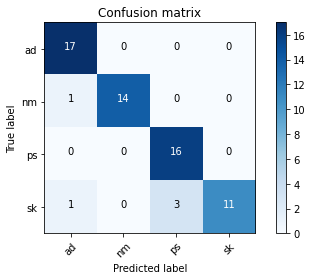

In [41]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

classes_names = ['ad', 'nm', 'ps', 'sk']

plot_confusion_matrix(cm, classes_names, False)

Normalized confusion matrix
[[1.         0.         0.         0.        ]
 [0.06666667 0.93333333 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.06666667 0.         0.2        0.73333333]]


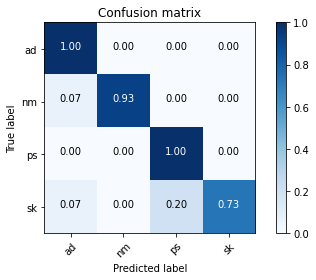

In [42]:
plot_confusion_matrix(cm, classes_names, True)

In [43]:
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_labels, y_pred))
print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=classes_names))

Confusion Matrix
[[17  0  0  0]
 [ 1 14  0  0]
 [ 0  0 16  0]
 [ 1  0  3 11]]
Classification Report
              precision    recall  f1-score   support

          ad       0.89      1.00      0.94        17
          nm       1.00      0.93      0.97        15
          ps       0.84      1.00      0.91        16
          sk       1.00      0.73      0.85        15

    accuracy                           0.92        63
   macro avg       0.93      0.92      0.92        63
weighted avg       0.93      0.92      0.92        63



In [44]:
cm_2 = confusion_matrix(test_labels, y_pred)

### True Positive

In [45]:
TruePositive= np.diag(cm_2)

In [46]:
print(TruePositive)
sumTruePositive = sum(TruePositive)
print('Sum of True Positive: ', sumTruePositive)

[17 14 16 11]
Sum of True Positive:  58


### False Positive

In [47]:
FalsePositive = []
for i in range(NUM_CLASSES):
    FalsePositive.append(sum(cm_2[:,i]) - cm_2[i,i])

In [48]:
print(FalsePositive)
sumFalsePositive = sum(FalsePositive)
print('Sum of False Positive: ', sumFalsePositive)

[2, 0, 3, 0]
Sum of False Positive:  5


### False Negative

In [49]:
FalseNegative = []
for i in range(NUM_CLASSES):
    FalseNegative.append(sum(cm_2[i,:]) - cm_2[i,i])

In [50]:
print(FalseNegative)
sumFalseNegative = sum(FalseNegative)
print('Sum of False Negative: ', sumFalseNegative)

[0, 1, 0, 4]
Sum of False Negative:  5


### True Negative

In [51]:
TrueNegative = []
for i in range(NUM_CLASSES):
    temp = np.delete(cm_2, i, 0)   # delete ith row
    temp = np.delete(temp, i, 1)  # delete ith column
    TrueNegative.append(sum(sum(temp)))

In [52]:
print(TrueNegative)
sumTrueNegative = sum(TrueNegative)
print('Sum of True Negative: ', sumTrueNegative)

[44, 48, 44, 48]
Sum of True Negative:  184


### Check TP + FP + FN + TN = Test set

In [53]:
l = len(test_labels)
for i in range(NUM_CLASSES):
    print(TruePositive[i] + FalsePositive[i] + FalseNegative[i] + TrueNegative[i] == l)

True
True
True
True


In [54]:
!pip3 install pycm==3.0

In [55]:
from pycm import *

In [56]:
py_cm = ConfusionMatrix(actual_vector=test_labels, predict_vector=y_pred)

In [57]:
print(py_cm)

Predict  0        1        2        3        
Actual
0        17       0        0        0        

1        1        14       0        0        

2        0        0        16       0        

3        1        0        3        11       





Overall Statistics : 

95% CI                                                            (0.85389,0.98738)
ACC Macro                                                         0.96032
ARI                                                               0.80031
AUNP                                                              0.94635
AUNU                                                              0.94492
Bangdiwala B                                                      0.86028
Bennett S                                                         0.89418
CBA                                                               0.85088
CSI                                                               0.85088
Chi-Squared                                             

In [58]:
AV_AUC = (py_cm.AUC[0] + py_cm.AUC[1] + py_cm.AUC[2] + py_cm.AUC[3])/len(py_cm.AUC)

In [59]:
print('Average AUC: ', AV_AUC)

Average AUC:  0.9449198273203824


In [60]:
AV_Sens = (py_cm.TPR[0] + py_cm.TPR[1] + py_cm.TPR[2] + py_cm.TPR[3])/len(py_cm.TPR)

In [61]:
print('Average Sensitivity: ', AV_Sens)

Average Sensitivity:  0.9166666666666667


In [62]:
AV_Spec = (py_cm.TNR[0] + py_cm.TNR[1] + py_cm.TNR[2] + py_cm.TNR[3])/len(py_cm.TNR)

In [63]:
print('Average Specificity: ', AV_Spec)

Average Specificity:  0.973172987974098
